In [1]:
%matplotlib notebook
import notebook

import torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import utils
from utils import load, AE, ResBlock2D, View, Flatten, as_shape, PairedTripletLoss, Encoder

import jnu as J

config = dict(
    device = "cuda:0",
    state_shape = (3,84,84),
    latent_shape = (64,),
    batch_size = 256,
    learning_rate = 0.0005,
    epochs = 10,
    margin=0.2,
)
config = SimpleNamespace(**config)


In [2]:
model = utils.S3N(config.state_shape, config.latent_shape).to(config.device)
#model.load_state_dict(torch.load("./S3N-(2,)-9.pt"))
optim = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
criterion = PairedTripletLoss(margin=config.margin)
#print(torchsummary.summary(model, config.state_shape))

In [3]:
dataset = [torch.from_numpy(ep[0]) for ep in utils.load(utils.FILES_VALIDATE, keys=["observation"])]
dataset = [(ep[:-1], ep[1:]) for ep in dataset]
dataset = ConcatDataset([TensorDataset(*ep) for ep in dataset])
loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, drop_last=True, pin_memory=True)

In [4]:
xt = dataset.datasets[0].tensors[0]
plt.ion()
fig = None
def plot():
    if config.latent_shape[0] == 2:
        global fig
        if fig is None:
            fig =plt.figure() 
        plt.clf()
        zt1, zt2 = utils.forward(model, xt, device=config.device)
        print(zt1.shape)
        plt.scatter(*zt1.cpu().numpy().T, alpha=0.1, marker=".")
        plt.scatter(*zt2.cpu().numpy().T, alpha=0.1, marker=".")
        fig.canvas.draw()

loss_msg = "Loss: {0}"
msg = J.HTML(loss_msg.format(0))
display(msg)

#config.epochs = 1000
for e in tqdm(range(config.epochs)):
    plot()
    for o1, o2 in loader:
        o1, o2 = o1.to(config.device, non_blocking=True), o2.to(config.device, non_blocking=True)
        optim.zero_grad()
        z1, z2 = model(o1, o2)
        loss = criterion(z1, z2)
        loss.backward()
        optim.step()
    
    msg.value = loss_msg.format(loss.item())
    #img.update(torch.sigmoid(y[0]))
    if not e % 3:
        torch.save(model.state_dict(), f"./S3N-{config.latent_shape}-{e}.pt")
torch.save(model.state_dict(), f"./S3N-{config.latent_shape}-{e}.pt")

HTML(value='Loss: 0')

TexMissing



(4959,) (4959,)


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4959), Output()), _d…

<IPython.core.display.Javascript object>


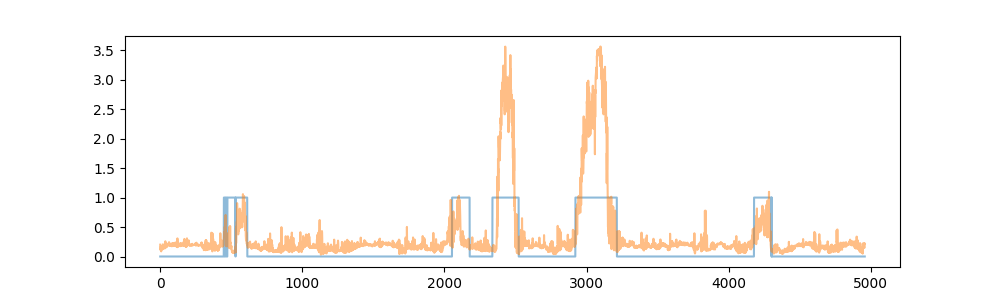

ZFighting



(4959,) (4959,)


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4959), Output()), _d…

<IPython.core.display.Javascript object>


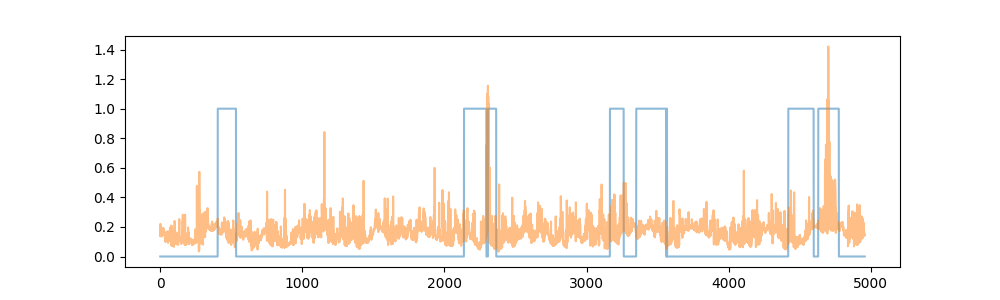

BoundaryHole



(88,) (88,)


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=88), Output()), _dom…

<IPython.core.display.Javascript object>


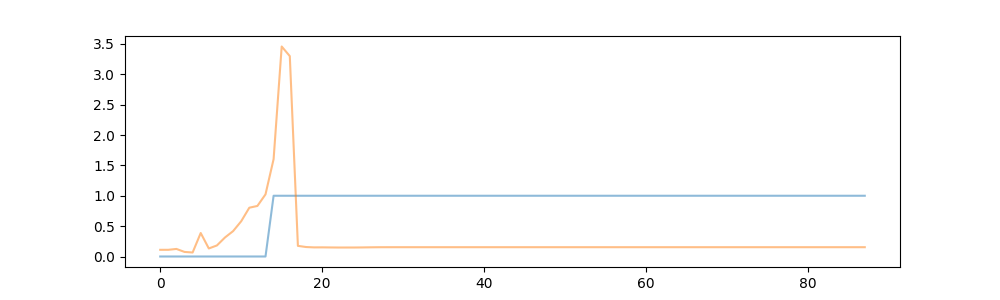

ZClipping



(4959,) (4959,)


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4959), Output()), _d…

<IPython.core.display.Javascript object>


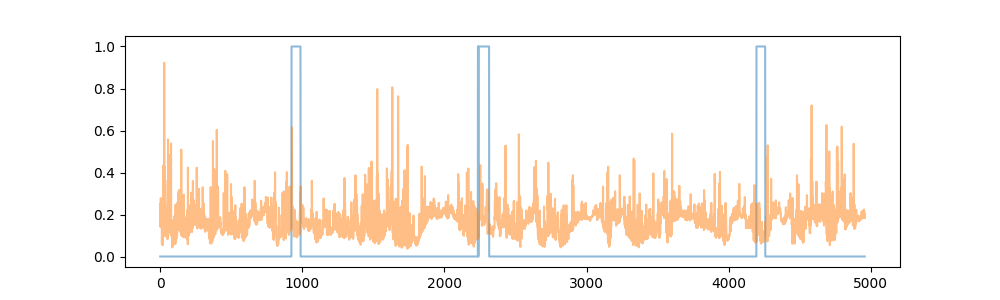

TexCorruption



(4959,) (4959,)


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4959), Output()), _d…

<IPython.core.display.Javascript object>


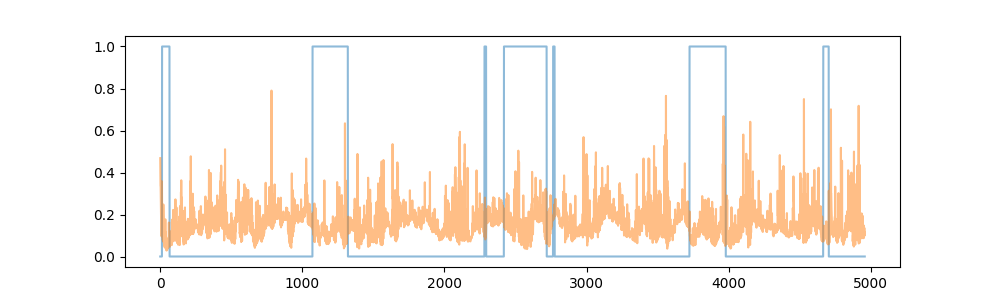

GeomClipping



(4959,) (4959,)


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4959), Output()), _d…

<IPython.core.display.Javascript object>


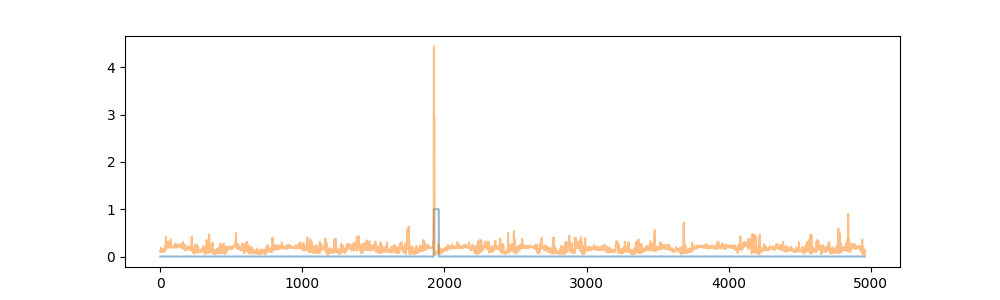

CameraClipping



(4959,) (4959,)


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4959), Output()), _d…

<IPython.core.display.Javascript object>


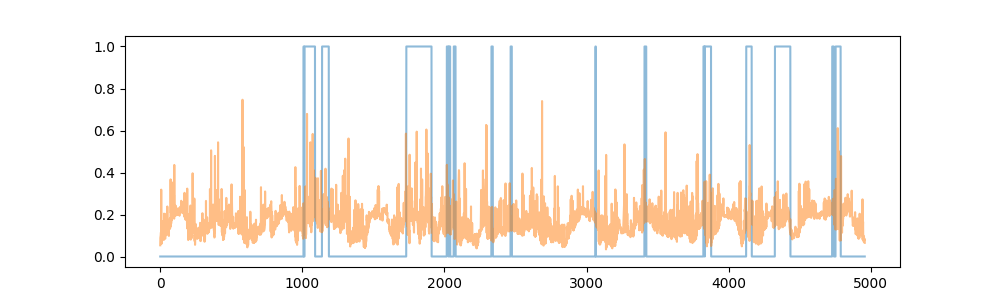

ScreenTear



(4959,) (4959,)


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4959), Output()), _d…

<IPython.core.display.Javascript object>


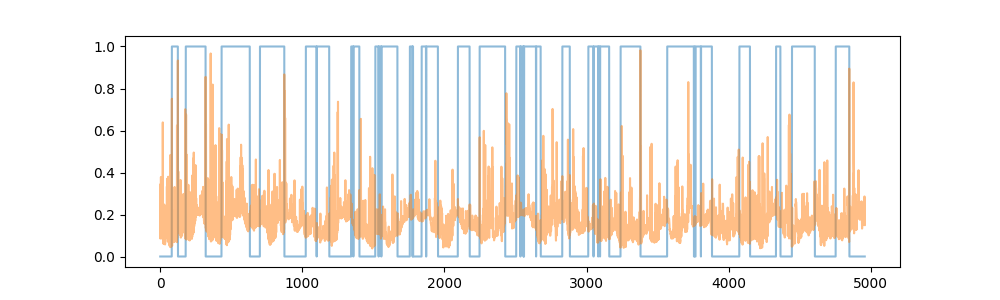

GeomCorruption



(4959,) (4959,)


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4959), Output()), _d…

<IPython.core.display.Javascript object>


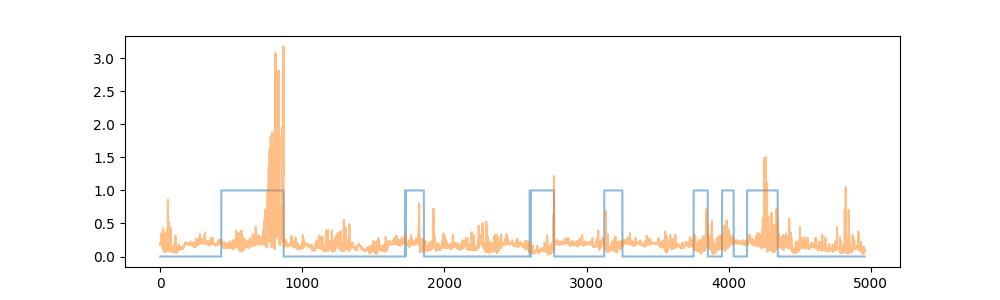

BlackScreen



(4959,) (4959,)


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4959), Output()), _d…

<IPython.core.display.Javascript object>


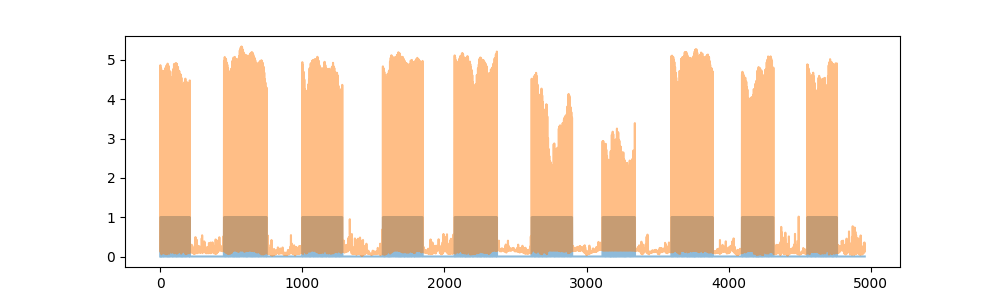

In [5]:
import os
T = 100
for i, file in enumerate(utils.FILES_TEST):
    name = os.path.splitext(os.path.split(file)[1])[0].replace("Geometry", "Geom").replace("Texture", "Tex")
    print(name)
    ys, ys_ = [], []
    i = 2 * i
    for x, y in utils.load(file, ['observation', 'bugmask']):
        #x, y = x[:100], y[:100]
        x = torch.from_numpy(x).to(config.device)
        x1_, x2_ = utils.forward(model, x, device=config.device)
        ys_.append(utils.L22_(x1_[:-1], x2_[1:]).cpu().numpy()) # score (1D)
        y = (y[...].sum(1, keepdims=True) > 0.)
        y = y.sum(-1).sum(-1).sum(-1)
        y = y[:-1] + y[1:]
        ys.append(y) # label (1D)
        break
    y, y_ = np.concatenate(ys), np.concatenate(ys_)
    print(y.shape, y_.shape)
    
    J.images(x, scale=3)
    plt.figure(figsize=(10,3))
    plt.tight_layout()
    plt.plot(np.arange(y.shape[0]), (y > T).astype(np.float32), alpha=0.5)
    plt.plot(np.arange(y_.shape[0]), np.log(1 + y_), alpha=0.5)
    
    
        